In [34]:
import lxml
from datetime import datetime
import os
import glob
from pathlib import Path
import polars as pl
import re
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from lxml import etree, objectify
sys.path.append('../infineac/')
import file_loader

%load_ext autoreload
%autoreload 2

PATH_DIR = "../data/Transcripts/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
files = list(Path(PATH_DIR).rglob("*.xml"))

In [5]:
events = file_loader.load_files_from_xml(files)

In [6]:
len(events)

58613

In [7]:
events_filt = [event for event in events if "date" in event.keys() and event['action'] == 'publish' and event['date'].year >= 2022 and event['version'] == "Final"]

In [31]:
russia = [True if "russia" in event['body_orig'].lower() else False for event in events_filt]

In [46]:
def get_russia(string):
    if "russia" in string.lower():
        if "sanctions" in string.lower():
            return "russian & sanctions"
        else: return "russia"
    if "sanctions" in string.lower():
        return "sanctions"
    else: return 'none'

In [47]:
russia = [get_russia(event['body_orig']) for event in events_filt]

In [66]:
russia_count = [event['body_orig'].lower().count('russia') for event in events_filt]

In [54]:
russia.count('russia')

7553

In [28]:
dates = [event['date'] for event in events_filt if "date" in event.keys()]
numeric_values = mdates.date2num(dates)

In [67]:
df = pd.DataFrame({'date': dates, 'dates_num' : numeric_values, 'russia': russia, 'russia_count': russia_count})

,date,dates_num,russia,russia_count
10,2022-04-27 13:00:00,19109.541667,russia,1
13,2022-06-15 13:30:00,19158.562500,sanctions & russia,2
25,2022-03-09 14:30:00,19060.604167,sanctions & russia,13
26,2022-03-09 00:10:00,19060.006944,russia,1
36,2022-08-02 14:30:00,19206.604167,russia,5
...,...,...,...,...
50810,2023-04-27 01:00:00,19474.041667,russia,7
50831,2023-02-15 12:00:00,19403.500000,russia,19
50854,2023-01-25 22:00:00,19382.916667,russia,6
50863,2023-04-21 13:00:00,19468.541667,russia,1


In [ ]:
sns.histplot(data=df[df], hue="russia", multiple="stack", bins=100)

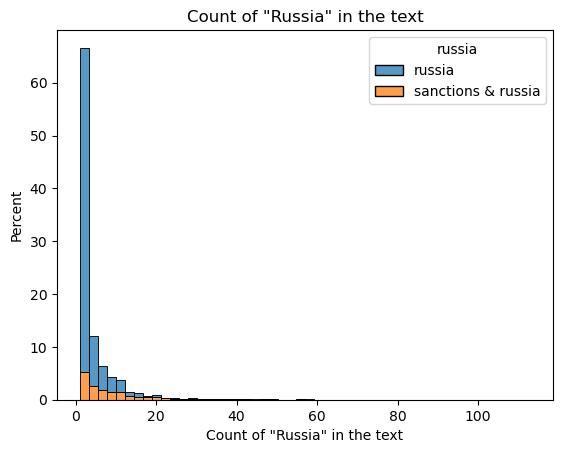

In [78]:
sns.histplot(df[df['russia_count']>=1], x='russia_count', hue="russia", bins=50, stat="percent", common_norm=True, multiple="stack")
plt.xlabel('Count of "Russia" in the text')
plt.ylabel('Percent')
plt.title('Count of "Russia" in the text')
plt.show()

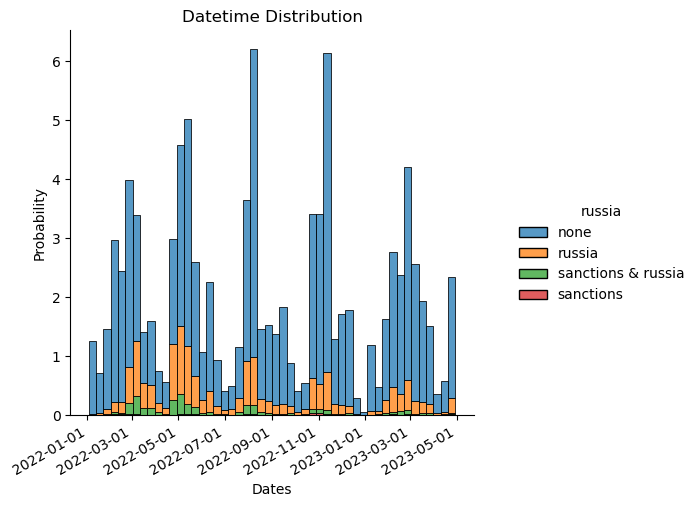

In [63]:
# plt.hist(numeric_values, bins=50)
# sns.histplot(numeric_values, bins=50)
sns.displot(df, x="dates_num", hue="russia", bins=50, stat="percent", common_norm=True, multiple="stack")
# plt.plot_date(dates, numeric_values, '-o')  # '-o' adds markers on the data points
plt.xlabel('Dates')
plt.ylabel('Probability')
plt.title('Datetime Distribution')

# Add x-axis ticks and labels
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Customize date format as needed

plt.gcf().autofmt_xdate()  # Adjusts the date labels rotation for better visibility

plt.show()

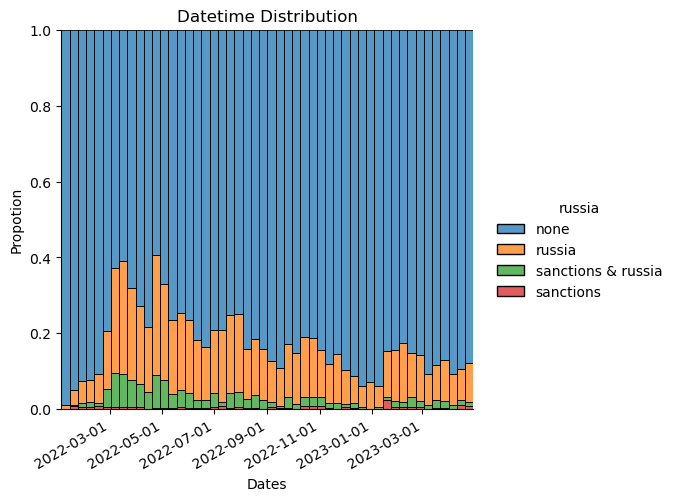

In [62]:
# plt.hist(numeric_values, bins=50)
# sns.histplot(numeric_values, bins=50)
sns.displot(df, x="dates_num", hue="russia", bins=50, stat="proportion", common_norm=True, multiple="fill")
# plt.plot_date(dates, numeric_values, '-o')  # '-o' adds markers on the data points
plt.xlabel('Dates')
plt.ylabel('Propotion')
plt.title('Datetime Distribution')

# Add x-axis ticks and labels
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Customize date format as needed

plt.gcf().autofmt_xdate()  # Adjusts the date labels rotation for better visibility

plt.show()

In [35]:
len(set(dates))

22

In [38]:
counts = {}
for num in dates:
    if num in counts:
        counts[num] += 1
    else:
        counts[num] = 1

(array([0.00102585, 0.00165846, 0.00126522, 0.00160717, 0.00177814,
        0.00170975, 0.00234236, 0.00396663, 0.00463343, 0.00497538,
        0.00249624, 0.00220558, 0.00328272, 0.00348789, 0.00227397,
        0.00283819, 0.00357338, 0.00283819, 0.01831145, 0.06327794,
        0.87045206]),
 array([2002., 2003., 2004., 2005., 2006., 2007., 2008., 2009., 2010.,
        2011., 2012., 2013., 2014., 2015., 2016., 2017., 2018., 2019.,
        2020., 2021., 2022., 2023.]),
 <BarContainer object of 21 artists>)

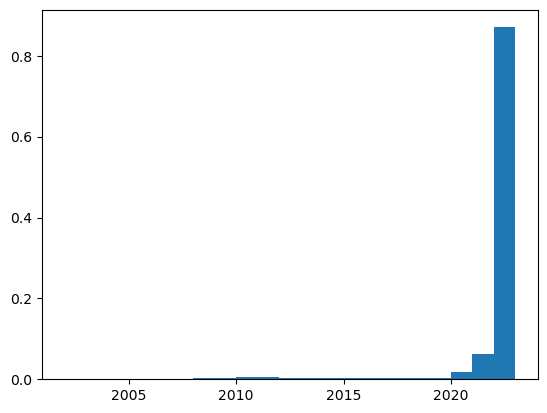

In [37]:
plt.hist(dates, density=True, bins=21)

In [5]:
keys_to_keep = ['file', 'body_orig']

In [8]:
events_new_trimmed = [{key: event[key] for key in keys_to_keep} for event in events_new]

In [9]:
eventsDF = pl.from_dicts(events_new_trimmed)

In [28]:
eventsDF = eventsDF.with_columns(pl.col("body_orig").str.count_match('(E|e)lections').alias("elections_count"))
eventsDF = eventsDF.with_columns(pl.col("body_orig").str.count_match('(S|s)anctions').alias("sanctions_count"))
eventsDF = eventsDF.with_columns(pl.col("body_orig").str.count_match('(R|r)ussia').alias("russia_count"))

In [37]:
len(eventsDF.filter(pl.col("elections_count") > 0))

1535

In [36]:
len(eventsDF.filter((pl.col("sanctions_count") > 0) & (pl.col("russia_count") > 0)))

1533

In [7]:
file = "../data/Transcripts/2022/15232031_T.xml"

In [14]:
for _, elem in etree.iterparse(file):
            tag = elem.tag
            if tag is not None:
                text = elem.text
                if tag == "Body":
                    break

In [19]:
output = file_loader.extract_info_from_earnings_call_sep(conference_call_sep_raw)

NameError: name 'conference_call_sep_raw' is not defined

In [25]:
conference_call_sep_dict = file_loader.separate_earnings_call(text)

In [26]:
conference_call_sep_dict

{'corp_participants': '   *  Clive Graham Vacher\r\n      De La Rue plc - CEO &amp; Executive Director\r\n   *  Paul Sharma\r\n      De La Rue plc - Head of IR\r\n   *  Rob Harding\r\n      De La Rue plc - CFO &amp; Executive Director\r\n\r\n',
 'conf_participants': '   *  James Beard\r\n      Numis Securities Limited, Research Division - Analyst\r\n   *  Thomas Andrew Rands\r\n      Investec Bank plc, Research Division - Industrials Research Analyst\r\n\r\n',
 'presentation': "\r\nOperator   [1]\r\n--------------------------------------------------------------------------------\r\n (technical difficulty)\r\n [12] months ended 26th of March 2022. Thank you for joining us today, whether in the with us or via the webcast.\r\n The results were announced this morning eventually and are available on our website, www.delarue.com.\r\n I'm Louise Rich, Head of Investor Relations. And our CEO, Clive Vacher; and our CFO, Rob Harding, will present on the results for the year to you shortly. (Oper

In [27]:
corp_participants = conference_call_sep_dict["corp_participants"].split("*")
corp_participants = [
    [el.strip() for el in pair.split("\r\n") if el.strip()]
    for pair in corp_participants
    if pair.strip()
]
corp_participants_colapsed = [",  ".join(pair) for pair in corp_participants]

# Conference Call Participants
conf_participants = conference_call_sep_dict["conf_participants"].split("*")
conf_participants = [
    [el.strip() for el in pair.split("\r\n") if el.strip()]
    for pair in conf_participants
    if pair.strip()
]
conf_participants_colapsed = [",  ".join(pair) for pair in conf_participants]

In [32]:
part = conference_call_sep_dict["presentation"]

In [28]:
corp_participants_colapsed

['Clive Graham Vacher,  De La Rue plc - CEO &amp; Executive Director',
 'Paul Sharma,  De La Rue plc - Head of IR',
 'Rob Harding,  De La Rue plc - CFO &amp; Executive Director']

In [29]:
conf_participants_colapsed

['James Beard,  Numis Securities Limited, Research Division - Analyst',
 'Thomas Andrew Rands,  Investec Bank plc, Research Division - Industrials Research Analyst']

In [42]:
split_symbol = (
    "------------------------------------"
    "--------------------------------------------\r\n"
)
part_split = part.split(split_symbol)
part_split = [el.strip() for el in part_split]  # if el.strip()
# removes the double spaces between speaker and his position
# presentation=[re.sub(' +', ' ', el.strip()) for el in presentation if el.strip()]

# Split presentation into speakers and texts
speakers = [
    el
    for el in part_split
    if re.match(".+  \[\d+\]", el) or (re.match("\[\d+\]", el) and len(el) <= 5)
]

texts = [el for el in part_split if el not in speakers]

n_speakers = len(speakers)
n_texts = len(texts)

# Note: if no speaker or no text is found, the presentation is not included
if n_speakers == 0:
    print("Warning: No speakers present at " + type)
if n_texts == 0:
    print("Warning: No texts present " + type)

regex_pattern = r"(.*)\s{2,}\[(\d+)\]$"

In [43]:
speakers

['Operator   [1]',
 'Clive Graham Vacher,  De La Rue plc - CEO &amp; Executive Director   [2]',
 'Rob Harding,  De La Rue plc - CFO &amp; Executive Director   [3]',
 'Clive Graham Vacher,  De La Rue plc - CEO &amp; Executive Director   [4]']

In [44]:
speakers_ordered = [
    [
        int(re.search(regex_pattern, el).group(2)),
        re.search(regex_pattern, el).group(1).strip(),
    ]
    if not re.match("\[\d+\]", el)
    else [
        int(re.search(r"\[(\d+)\]", el).group(1)),
        "unknown",
    ]  # if the speaker is not mentioned
    for el in speakers
]

In [24]:
presentation = file_loader.extract_info_from_earnings_call_sep(conference_call_sep_raw)

AttributeError: 'NoneType' object has no attribute 'group'

In [17]:
file_loader.extract_info_from_earnings_call_body(text)

AttributeError: 'NoneType' object has no attribute 'group'

In [10]:
file_loader.load_file_from_xml(file)

IndexError: tuple index out of range

In [55]:
presentation = eventsDF.filter(pl.col("file")=="577970_T").select("qa").item()

In [63]:
presentation

""
struct[4]
"{1,""Operator"",""operator"",""Thank you, sir. The floor is now open for questions. If you do have a question or a comment, please press the numbers one followed by four on your touch-tone phone. If at any point your question has been answered, you may remove yourself from the queue by pressing the pound key. We do ask that while you pose your question, that you please pick up your handsets to provide optimum sound quality. Once again, ladies and gentlemen, that is one then four on your touch-tone phone at this time. Please hold while we poll for questions. Thank you. Our first question is coming from Gary Townsend of Friedman Billings. Please state your question or comment.""}"
"{2,""GARY TOWNSEND, FRIEDMAN BILLINGS RAMSEY"",""conference"",""Kirk, good morning. How are you?""}"
"{3,""KIRK WALTERS, CHITTENDEN CORPORATION - CHIEF FINANCIAL OFFICER"",""cooperation"",""I'm doing fine. How are you doing, Gary?""}"
"{4,""GARY TOWNSEND, FRIEDMAN BILLINGS RAMSEY"",""conference"",""Doing fine, too. Thank you. Could you discuss just the economic environment in your markets and competitive environment, as well, please?""}"
"{5,""KIRK WALTERS, CHITTENDEN CORPORATION - CHIEF FINANCIAL OFFICER"",""cooperation"",""Sure. From an economic standpoint, as you know, the primary markets that we're in -- in Vermont, Massachusetts, New Hampshire and Maine -- have tended to be fairly steady markets, not markets that we've seen, either boom or bust type of activity. And I think we continue to see in our markets a, you know, a decent, steady activity in terms of our commercial businesses, albeit you certainly are starting to feel a little bit of the slowdown that has impacted other parts of the nation on a more dramatic basis throughout the year. So I would say, from an economic standpoint, we are continuing to see a little slowdown, but all-in-all the markets have remained pretty steady. And in particular on the residential housing sector, we tend to be in markets that have not had much in terms of inventory of the lower income housing. So those markets have probably remained stronger than some other parts in the country. From a competitive standpoint, it continues, certainly, to be a very competitive environment out there. We, of course, during the year did have some consolidations and such that occurred, and, you know, in some of our markets, which we overall benefited from. But I think, in terms of looking at our overall primary competitors, which, you know, very market-to-market and certainly in size of institution, the banking industry is still being (ph) very active out there and certainly still very competitive, particularly on the commercial lending side.""}"
"{6,""GARY TOWNSEND, FRIEDMAN BILLINGS RAMSEY"",""conference"",""It strikes me you're kind of levered to an economic recovery. How, if -- do you have a comment? Or...""}"
"{7,""KIRK WALTERS, CHITTENDEN CORPORATION - CHIEF FINANCIAL OFFICER"",""cooperation"",""You cut out some there on me, Gary.""}"
"{8,""GARY TOWNSEND, FRIEDMAN BILLINGS RAMSEY"",""conference"",""Well, I guess I'm just seeing -- you have -- let's see. Are you -- how well positioned are you? It seems that you've positioned yourselves for an economic recovery. As that recovery begins to come through, should tend to work very well for you in terms of accelerated earnings growth. Would you agree?""}"
"{9,""KIRK WALTERS, CHITTENDEN CORPORATION - CHIEF FINANCIAL OFFICER"",""cooperation"",""I would agree that we're, overall we think we're pretty well positioned for an economic recovery, and also riding this one out if it ends up, be a while, you know, a while in coming in terms of the recovery. Certainly, if you look at our loan-to-deposit ratio, which is around 78 percent, we do have excess core deposit funding that we would love to be in a spot of putting more and more of that into the loan part of the equation instead of our investment portfolio. And I think we have tried to be pretty thoughtful and cautious abo

In [54]:
for event, elem in etree.iterparse(file):
    if elem is not None:
        print(elem.tag)

Headline
Body
EventStory
eventTitle
city
companyName
companyTicker
startDate
Event


In [10]:
import xml.etree.ElementTree as ET
mytree = ET.parse('data/2022/1000015_T.xml')
myroot = mytree.getroot()

In [11]:
## attributes
myroot.attrib

{'Id': '1000015',
 'lastUpdate': 'Tuesday, May 3, 2022 at 2:53:00pm GMT',
 'eventTypeId': '1',
 'eventTypeName': 'Earning Conference Call/Presentation'}

In [33]:
myroot.findall('startDate')[0].text

'21-Jul-05 2:30pm GMT'

In [31]:
print(
myroot.findall('eventTitle')[0].text,
myroot.findall('startDate')[0].text,
myroot.findall('companyName')[0].text,
myroot.findall('companyTicker')[0].text,
myroot.findall('city')[0].text,
sep="\n")

Q2 2005 Chittenden Earnings Conference Call
21-Jul-05 2:30pm GMT
People's United Financial Inc
PBCT.OQ^D22
BUFFALO
